# Aprendizaje Supervisado - Árboles de Decisión

Los árboles de decisión son uno de los algoritmos de aprendizaje supervisado más utilizados por su simplicidad y facilidad de interpretación. Estos, como su nombre lo indica, construye un árbol para predecir una variable de salida en la que los nodos intermedios y las ramas representan las decisiones que se toman sobre un conjunto de datos. Los nodos finales, es decir las hojas, contienen la predicción que se genera a partir de las decisiones que llevan a ella.

![DecisionTree](imagenes/DT.jpg)

## Importamos las Librerías

In [1]:
%matplotlib inline

import numpy as np    #Para el manejo de arreglos
import pandas as pd   #Para el manejo de conjuntos de datos, tratados como tablas
import seaborn as sns #Para la construcción y visualización de gráficos
import matplotlib.pyplot as plt #Pra la construcción de gráficos

from sklearn.tree import DecisionTreeClassifier # Clase para entrenar de árboles de decisión
from sklearn import preprocessing #Para transformar y escalar los datos
from sklearn import metrics #Las métricas de rendimiento de un clasificador
from sklearn import model_selection #Para el particionamiento de los conjuntos de datos


## 1. Empecemos con un ToySet

Vamos a crear un conjunto de datos de juguete basado en 3 Gaussianas con algo de ruido para ver el comportamiento del árbol de decisión, trazando las fronteras de decisión.

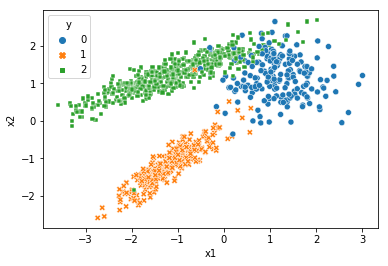

In [2]:
#Generamos el conjunto de datos de 3 clases.
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.2, 0.3, 0.5],
                           class_sep=1.2, random_state=34)

#Creamos un DataFrame a partir del conjunto de datos, para visualizarlo
df = pd.DataFrame(data=X, columns=["x1", "x2"])
df['y'] = y

sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="tab10", style="y")

Un árbol de decisión simple construido sobre este conjunto de datos dividirá, iterativamente, los puntos a lo largo de uno u otro eje. Veamos como son las fronteras de decisión construídas por un árbol con los parámetros por deecto del algoritmo.

In [3]:
#Entrenamos un árbol de decisión en el conjunto de datos
dtc = DecisionTreeClassifier()
dtc.fit(X,y)

DecisionTreeClassifier()

In [4]:
###
# Esta función la usaremos para mostrar las fronteras de decisión de los clasificadores entrenados
###
import matplotlib

def plot_decision_function(X, y, clf, ax=None, cmap="jet"):
    ax = ax or plt.gca()
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    n_classes = len(np.unique(y))
    
    ax.contourf(xx, yy, Z, alpha=0.2, cmap=cmap, levels=np.arange(n_classes + 1) - 0.5, zorder=1)  
    m = ['o', 's', 'v', '^', '<', '>', '8', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
    l = np.unique(y)
    rgb = matplotlib.cm.get_cmap(cmap)(np.linspace(0.0, 1.0, l.shape[0]))

    for l in np.unique(y):
        if (np.unique(y).shape[0] == 3 and l == 1):
            ax.scatter(X[y==l, 0], X[y==l, 1], alpha=0.6, c=[0.17,0.62,0.17], edgecolor=[0.17,0.62,0.17], cmap=cmap, marker=m[l])
        else:
            ax.scatter(X[y==l, 0], X[y==l, 1], alpha=0.6, c=rgb[l], edgecolor=rgb[l], cmap=cmap, marker=m[l])
    #ax.scatter(X[:, 0], X[:, 1], alpha=0.5, c=y, edgecolor="k", cmap="jet")

Text(0.5,1,'Fronteras de decisión')

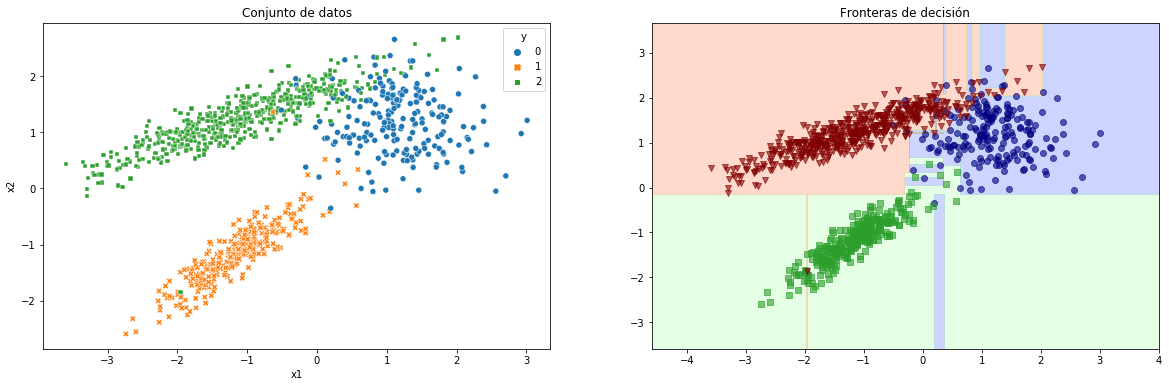

In [5]:
#Visualizamos el conjunto de datos y la frontera de decisión
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sns.scatterplot(data=df, x="x1", y="x2", hue="y", palette="tab10", style="y", ax=ax1)
ax1.set_title('Conjunto de datos')

plot_decision_function(X, y, dtc, ax2)
ax2.set_title('Fronteras de decisión')

Cuándo se usan los parámetros por defecto, el árbol se expande por completo lo que puede llevar a un sobreajuste del clasificador, tal como puede evidenciarse en la frontera de decisión que se ha pintado.

Veamos como serían las fronteras si controlamos la profundidad del árbol. En este caso, vamos a entrenar 3 árboles de profundidades 1, 3 y 5 para ver las diferencias.

Text(0.5,1,'Árbol de profundidad 5')

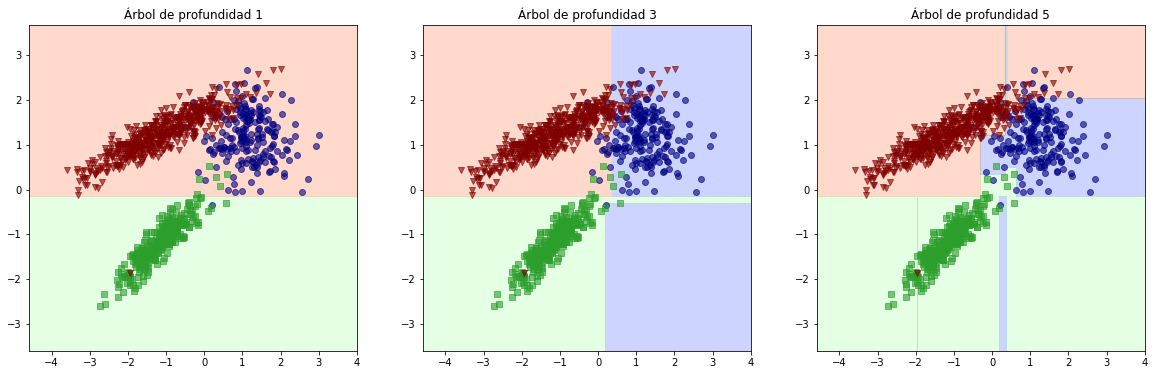

In [6]:
#Árbol con profundidad 1
dtc_1 = DecisionTreeClassifier(max_depth=1)
dtc_1.fit(X,y)

#Árbol con profundidad 3
dtc_3 = DecisionTreeClassifier(max_depth=3)
dtc_3.fit(X,y)

#Árbol con profundidad 5
dtc_5 = DecisionTreeClassifier(max_depth=5)
dtc_5.fit(X,y)

#Visualizamos las fronteras de decisión
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

plot_decision_function(X, y, dtc_1, ax1)
ax1.set_title('Árbol de profundidad 1')

plot_decision_function(X, y, dtc_3, ax2)
ax2.set_title('Árbol de profundidad 3')

plot_decision_function(X, y, dtc_5, ax3)
ax3.set_title('Árbol de profundidad 5')

Observe que a medida que aumenta la profundidad las fronteras de decisión empiezan a  tomar formas extrañas; por ejemplo, a una profundidad de cinco, hay una región roja alta y delgada en medio de la zona verde. Está claro que esto es menos un resultado de la verdadera distribución intrínseca de los datos y más un resultado de el ruido en los datos. Es decir, este árbol a pesar de tener cinco niveles de profundidad, claramente sobrepasa nuestros datos.

## 2. Ahora usemos un árbol de decisión sobre el conjunto de datos de las compras

Veámos como se comporta el árbol de decisión con un conjunto de datos que tiene datos numéricos y categóricos, para ello usemos el conjunto de datos de las compras.

In [7]:
#Leemos el conjunto de datos como un DataFrame
dataset = pd.read_csv('datos/Social_Network_Ads.csv')

dataset.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [8]:
#Obtenemos las matriz de datos y el vector de clases
X = dataset.values[:,1:4]
y = dataset.values[:,4].astype(int)
Xn = dataset.columns[1:4]

In [9]:
#Convertimos la variable categórica a numéricas
le_gen = preprocessing.LabelEncoder()
le_gen.fit(['Male','Female'])
X[:,0] = le_gen.transform(X[:,0]) 

print(X[:5,:]) 

[[1 19 19000]
 [1 35 20000]
 [0 26 43000]
 [0 27 57000]
 [1 19 76000]]


In [10]:
#Dividimos el conjunto de datos
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

In [13]:
#Entrenamos el árbol de decisión, en este caso usemos entropía y definamos una profundidad de 3
dtc = DecisionTreeClassifier(max_depth=5, criterion="entropy")
dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

Precisión del clasificador: 92.50 

Matriz de Confusión: 
 [[76  3]
 [ 6 35]]


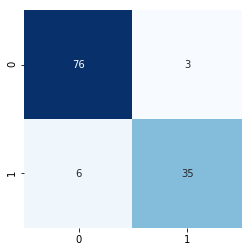

In [14]:
#Evaluamos el árbol
y_pred = dtc.predict(X_test)

#Calculamos la precisión y mostramos la matriz de confusión
acc = metrics.accuracy_score(y_test, y_pred)
mat = metrics.confusion_matrix(y_test, y_pred)

print ("Precisión del clasificador: %.2f " %(acc*100.0) )
print ("\nMatriz de Confusión: \n", mat)

#Esta es otra forma de ver la matriz de confusión
sns.heatmap(mat, square=True, annot=True, fmt="d", cbar=False, cmap="Blues")

## 3. Visualicemos el árbol

Una de las ventajas de los árboles es que se pueden visualizar para interpretar las decisiones que se están tomando en el mismo.

In [15]:
#Nota: en caso de no tener instalas las bibliotecas pydotplus y graphviz, descomente las siguientes líneas para instalarlas
# !conda install -c conda-forge pydotplus -y
# !conda install -c conda-forge python-graphviz -y

[Text(143.999,205.737,'X[1] <= 43.5\nentropy = 0.946\nsamples = 280\nvalue = [178, 102]'),
 Text(63.2963,168.33,'X[2] <= 90500.0\nentropy = 0.676\nsamples = 202\nvalue = [166, 36]'),
 Text(25.3185,130.923,'X[1] <= 36.5\nentropy = 0.224\nsamples = 166\nvalue = [160, 6]'),
 Text(12.6593,93.5167,'entropy = 0.0\nsamples = 109\nvalue = [109, 0]'),
 Text(37.9778,93.5167,'X[2] <= 83500.0\nentropy = 0.485\nsamples = 57\nvalue = [51, 6]'),
 Text(25.3185,56.11,'X[2] <= 67500.0\nentropy = 0.376\nsamples = 55\nvalue = [51, 4]'),
 Text(12.6593,18.7033,'entropy = 0.0\nsamples = 27\nvalue = [27, 0]'),
 Text(37.9778,18.7033,'entropy = 0.592\nsamples = 28\nvalue = [24, 4]'),
 Text(50.637,56.11,'entropy = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(101.274,130.923,'X[2] <= 133500.0\nentropy = 0.65\nsamples = 36\nvalue = [6, 30]'),
 Text(88.6148,93.5167,'X[2] <= 107500.0\nentropy = 0.795\nsamples = 25\nvalue = [6, 19]'),
 Text(75.9556,56.11,'entropy = 0.0\nsamples = 8\nvalue = [0, 8]'),
 Text(101.274,56.11

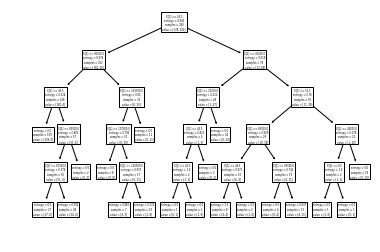

In [16]:
from sklearn import tree
tree.plot_tree(dtc) 

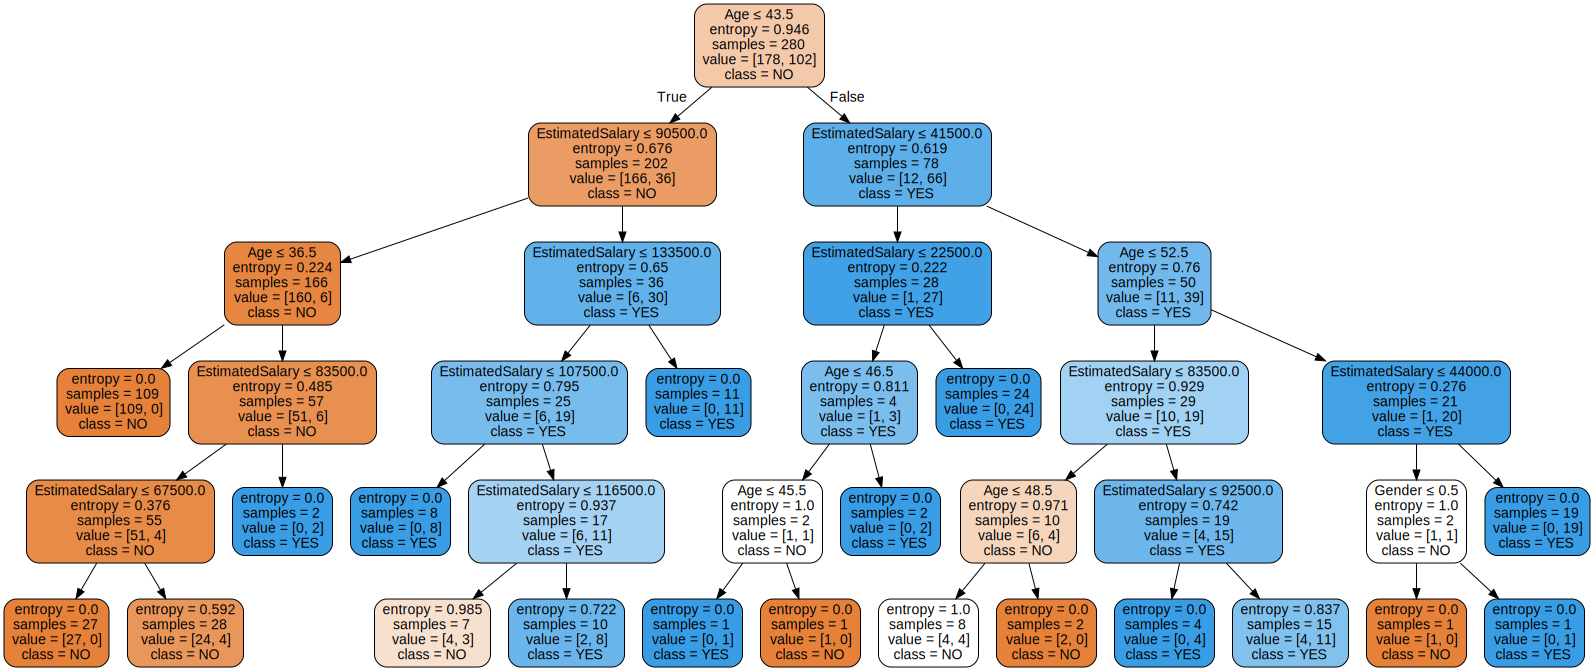

In [17]:
import graphviz
dot_data = tree.export_graphviz(dtc, out_file=None, 
                     feature_names=Xn,  
                     class_names=["NO","YES"],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 